<div style="text-align: center;">
    <h1> <font style="bold"> TD VI: Inteligencia Artificial </font></h1>
    <h2><font style="bold">Trabajo práctico 2 </font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Azul</li>
        <li>Gonzalez Rocio</li>
        <li>Guledjian Patricio</li>
        </ul>
    </h4>
</div>

In [198]:
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import xgboost as xgb


In [174]:
# Load the competition data
df = pd.read_csv("competition_data.csv")

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 57 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   accepts_mercadopago                199972 non-null  bool   
 1   available_quantity                 199972 non-null  int64  
 2   avg_gmv_item_domain_30days         195607 non-null  float64
 3   avg_gmv_item_sel                   195607 non-null  float64
 4   avg_gmv_seller_bday                195607 non-null  float64
 5   avg_qty_orders_item_domain_30days  195607 non-null  float64
 6   avg_qty_orders_item_sel_30days     195607 non-null  float64
 7   avg_si_item_sel_30day              195607 non-null  float64
 8   benefit                            199971 non-null  float64
 9   boosted                            199972 non-null  bool   
 10  category_id                        199972 non-null  object 
 11  conversion                         1807

# Análisis Exploratorio de Datos

## Análisis de las variables numéricas

Comenzaremos analizando las variables numéricas que podrían no aportarnos valor a la predicción del modelo. 

In [176]:
df_num = df.select_dtypes(include='number')
df_bool = df.select_dtypes(include='bool')

In [177]:
x = df[["boosted", "accepts_mercadopago", "etl_version"]]  
for column in df_bool:  
   print(column) 
   print(df_bool[column].nunique())
   print("\t")

for column in df_num:  
   print(column) 
   print(df_num[column].nunique())
   print("\t")

accepts_mercadopago
1
	
boosted
1
	
free_shipping
2
	
fulfillment
2
	
available_quantity
6937
	
avg_gmv_item_domain_30days
17727
	
avg_gmv_item_sel
18652
	
avg_gmv_seller_bday
18634
	
avg_qty_orders_item_domain_30days
16760
	
avg_qty_orders_item_sel_30days
15129
	
avg_si_item_sel_30day
15527
	
benefit
2
	
conversion
2
	
health
35
	
product_id
4440
	
offset
209
	
original_price
6469
	
price
6029
	
print_position
10902
	
qty_items_dom
4193
	
qty_items_sel
1462
	
sold_quantity
5718
	
total_asp_item_domain_30days
17729
	
total_asp_item_sel_30days
18651
	
total_gmv_domain_bday
17717
	
total_gmv_item_30days
45132
	
total_items_domain
10309
	
total_items_seller
3240
	
total_orders_domain_30days
7882
	
total_orders_item_30days
635
	
total_orders_sel_30days
4413
	
total_si_domain_30days
9157
	
total_si_item_30days
850
	
total_si_sel_30days
5301
	
total_visits_domain
17646
	
total_visits_item
9618
	
total_visits_seller
17762
	
user_id
139110
	
ROW_ID
19211
	


Notamos que las variables *accepts_mercadopago* y *boosted* contienen un unico valor posible. Por lo que lo unico que le aportará al modelo es tiempo computacional, que no queremos!

Por otro lado, las variables *product_id* y *user_id* no las tendremos en cuenta porque en su mayor proporción se encuentran vacias y no aportan información a la predicción. 

Es importante destacar que notamos 4365 registros con muchas columnas nulas en nustro dataset. Algunos de estos registros estan presentes en la base de testing, por eso se decide no hacer estimaciones de estos valores ya que la base de testing es un reflejo de la realidad y no debería ser alterado. 

En el siguiente bloque de código se muestran los registros con columnas con gran proporcion de informacion nula...


In [178]:
mask = df_num["avg_gmv_item_domain_30days"].isna()
del df_num
df[mask]


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
80,True,931,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,83887,321,36382,340b7d69-ee64-4dba-99c7-03066dbcb5f3,436633616.0,Garantía del vendedor: 30 días,NaN
89,True,1000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,80838,19,6089,60f2a17a-5f37-4238-9b68-85c250bed879,83963350.0,Garantía del vendedor: 6 meses,NaN
93,True,965,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,7997283,661,176129,028c9df1-483a-451f-b206-59d2b3aca377,87061384.0,NaN,NaN
135,True,600,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,13523,187,49282,0615356b-9074-4852-b3de-abd937b17362,533754597.0,Sin garantía,NaN
168,True,10,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,9608,32,3615,ad951016-9fe1-4724-8c53-b4c96f6626f2,317777998.0,Garantía de fábrica: 1 años,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199681,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,4120792,87,57957,45b4e692-868d-44b9-a9d7-27019e32b408,87070874.0,NaN,18920.0
199697,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,8711980,28,57084,8ee8eb73-beb3-45f3-abb6-c30d36d92da7,132089611.0,NaN,18936.0
199712,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,77042,9,27758,35d2fa9f-0a72-4a74-93bb-47d17fe3e397,389010382.0,1 año MAKITA Argentina,18951.0
199856,True,700,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,102610,170,289510,21b5457b-48d3-4ffa-b7f8-a711de5cf8f8,158340181.0,Garantía del vendedor: 6 meses,19095.0


In [179]:
%%capture
df.drop(columns=["product_id", "user_id", "accepts_mercadopago", "boosted"])

## Análisis las variables categoricas

In [180]:
df_categoricas = df.select_dtypes(include='object')

In [181]:
for column in df_categoricas:  
   print(column) 
   print(df_categoricas[column].nunique())
   print("\t")

category_id
2284
	
date
31
	
deal_print_id
196744
	
domain_id
1742
	
etl_version
1
	
full_name
2280
	
is_pdp
2
	
item_id
27695
	
listing_type_id
2
	
logistic_type
7
	
main_picture
26961
	
platform
4
	
print_server_timestamp
196780
	
site_id
1
	
tags
1227
	
title
26745
	
uid
159996
	
warranty
1288
	


#### Primer Analisis

- Se eliminan las variables de id (category_id, deal_print_id, domain_id, item_id) del analisis: no son representativas para la prediccion.
- se separan las variables temporales (date, print_server_timestamp) para analisis posterior.
- se elimina las variables etl_version, site_id al tener solo una categoria.
- se elimina las variables full_name, main_picture, tags, title, uid y warranty porque no es representativa.
- is_pdp, listing_type_id, logistic_type y platform pueden resultar interesantes para el analisis.
  
Procedemos a analizar las variables: is_pdp, listing_type_id y logistic_type.

#### Variables Categoricas

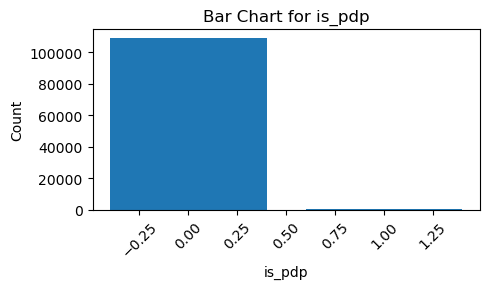

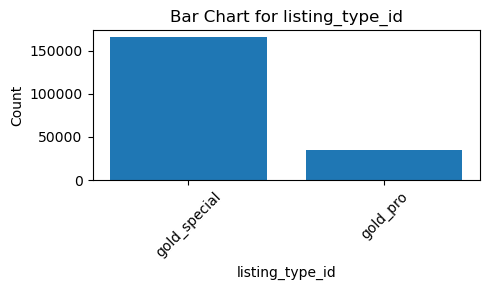

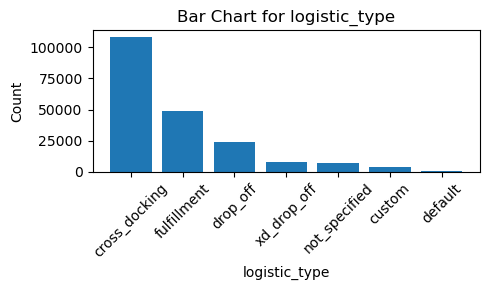

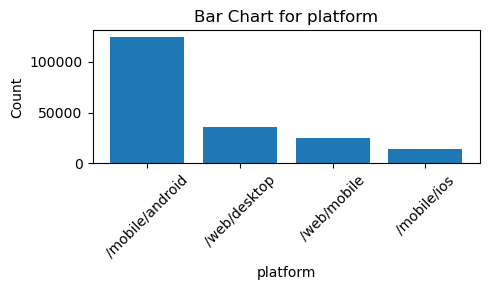

In [182]:
# Analicemos las variables no numericas de nuestro Dataset
df_categoricas = df_categoricas[["is_pdp","listing_type_id","logistic_type", "platform"]]

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(5, 3))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

#### Segundo Análisis:
- is_pdp presenta valores nulos tanto en train como en test, por lo que se decide no estimarlos ni eliminarlos. Se tomaran los registros nan como un posible valor y para normalizar la variable se utiliza One Hot Encoding. Como resultado, se agregaran dos columnas, ya que la tercera se da por entendida cuanda ambas sean falsas.
- listing_type se transforma a una variable booleana que es 1 cuando el listing es gold_special
- Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis. 
- Se realizara OneHotEncoding sobre la variable platform.   

In [183]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.

Realizamos one hot-encoding en la variable categoria *is_pdp*, *logistic_type* y *platform*.

In [184]:
# One Hot-Encoding
df = pd.get_dummies(df, 
    sparse=True,
    columns=[
        "logistic_type", 
        "platform", 
        "is_pdp"
    ],
    dtype=int
)

Convirtamos la variable categoria *listing_type_id* en booleana. Esta no presenta valores nulos. Si es gold_special será 1 y si es gold_pro será 0.

In [185]:
df["listing_type_id"] = df["listing_type_id"].apply(lambda x: 1 if x == "True" else 0)

Para continuar con el analisis notamos que la variable *warranty* es de tipo objeto pero en realidad esta detallando si tiene garantia (cuanto tiempo) o no. Por lo tanto, intentaremos modificar esa variable y analizaremos la garantía de los productos tiene o no una correlación con la conversión. 

In [186]:
def extraer_digitos(texto):
    # Utiliza una expresión regular para encontrar todos los dígitos en el texto
    digitos_encontrados = re.findall(r'\d+', str(texto))
    
    # Convierte los dígitos encontrados en una cadena única
    numeros = ''.join(digitos_encontrados)
    
    if len(numeros) == 0:
        # Si no se encontraron dígitos, que el dijito sea 0
        numeros = '0'

    # Convierte la cadena de números en un entero
    try:
        return int(numeros)
    except ValueError:
        return None  # En caso de que no se puedan convertir a un entero



# Aplica la función a la columna "Texto"
df['warranty'] = df['warranty'].apply(extraer_digitos)

# Aplicar la multiplicación a los valores menores o iguales a 12
df['warranty'] = df['warranty'].apply(lambda x: x * 30 if x <= 12 else x)


Los valores de la variable *warranty* se verán de la siguiente manera con las modificaciones hechas:

In [187]:
df["warranty"]

0         360
1           0
2           0
3          90
4          90
         ... 
199967      0
199968     20
199969      0
199970      0
199971      0
Name: warranty, Length: 199972, dtype: int64

Analicemos la correlación de la variable *warranty* con la variable *conversion*

In [188]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['warranty'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 778.6829853012749
P-value: 9.05413640372007e-122


A partir de el analisis de correlación (Chi cuadrado) notamos que existe una asociación significativa entre las dos variables categóricas. Por lo que la utilizaremos en el modelo para estimar la probabilidad de conversion. 

## Variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [189]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


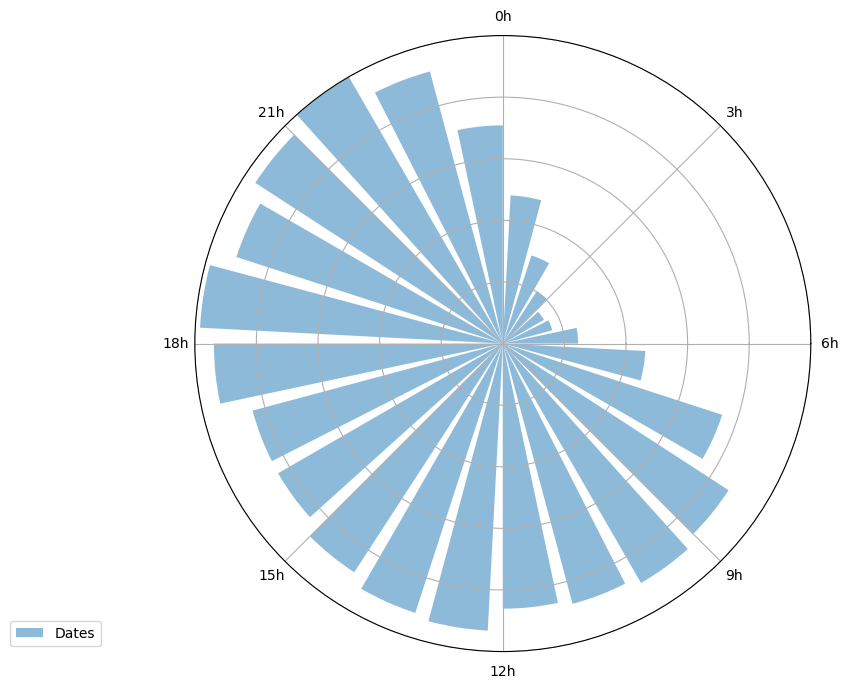

In [190]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

Para las horas:

In [191]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


Para los dias de la semana:

In [192]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

Para los dias del mes:

In [193]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [194]:
df = df.drop(columns = ["date","print_server_timestamp"])

In [195]:
df.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,platform_/web/desktop,platform_/web/mobile,is_pdp_False,is_pdp_True,hour_sin,hour_cos,weekday_sin,weekday_cos,day_sin,day_cos
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,1,0,1,0,0.000000,1.000000e+00,-0.433884,-0.900969,0.937752,0.347305
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,0,0,1,0,-0.707107,7.071068e-01,0.974928,-0.222521,0.207912,0.978148
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,0,0,1,0,-1.000000,-1.836970e-16,0.974928,-0.222521,0.994522,-0.104528
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,0,1,1,0,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,0.500000
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,0,0,1,0,-0.258819,-9.659258e-01,0.781831,0.623490,0.897805,-0.440394


# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

- Train: 80%
- Val: 20%
- Test: de testeo.

In [41]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [42]:
train_data = train_data.select_dtypes(include='number')
train_data = train_data.drop(columns=["ROW_ID"])
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["conversion"]), train_data['conversion'], test_size=0.2)
del train_data

In [43]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

## XG Boost

#### Prueba 1

Se realiza una primera prueba haciendo un unico job, pocas iteraciones y pocos splits en el cross validation con el fin de que demore poco y ver la performance rapidamente:

In [44]:
%%capture
model_xgb_1 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [46]:
%%capture
param_dist_1 = {'max_depth': stats.randint(1,20),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
# Cross Validation
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_1 = RandomizedSearchCV(model_xgb_1,param_dist_1, cv=cv, verbose=1, n_jobs=1,scoring='roc_auc',n_iter=3,random_state=41)
xgb_random_1.fit(X_train,y_train)

Los siguientes parametros fueron los que mejor performance le dieron al modelo:

In [47]:
xgb_random_1.best_params_

{'colsample_bytree': 0.3509236237449401,
 'learning_rate': 0.03304791033630588,
 'max_depth': 17,
 'min_child_weight': 2,
 'n_estimators': 293,
 'subsample': 0.7005672374101258}

El siguiente valor representa la performance del modelo (con un unico job):

In [48]:
xgb_random_1.best_score_

0.8896307052773369

In [49]:
# Predict on the evaluation set
y_pred_1 = xgb_random_1.predict_proba(X_test)[:,1]
y_pred_1

array([0.01287727, 0.00199072, 0.07021419, ..., 0.00455758, 0.07549037,
       0.00090161], dtype=float32)

In [50]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_1})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.1.csv", sep=",", index=False)

#### Prueba 2 (mejorando los parametros): 


In [52]:
%%capture
model_xgb_2 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [54]:
%%capture
param_dist_2 = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.01, 0.1),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

xgb_random_2 = RandomizedSearchCV(model_xgb_2,param_dist_2, cv=cv, verbose=1, n_jobs=5,scoring='roc_auc',n_iter=20,random_state=41)
xgb_random_2.fit(X_train,y_train)

In [55]:
xgb_random_2.best_params_

{'colsample_bytree': 0.7917956900820352,
 'learning_rate': 0.03825949129900566,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 610,
 'subsample': 0.5656637956484288}

In [56]:
xgb_random_2.best_score_

0.8947114423887064

Iteraciones de el modelo que mejor performance tuvo:

In [206]:
for i, score in enumerate(xgb_random_2.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8772
Iteraciones 2: auc_roc = nan
Iteraciones 3: auc_roc = 0.8944
Iteraciones 4: auc_roc = 0.8946
Iteraciones 5: auc_roc = 0.8909
Iteraciones 6: auc_roc = 0.8933
Iteraciones 7: auc_roc = nan
Iteraciones 8: auc_roc = 0.8878
Iteraciones 9: auc_roc = 0.8783
Iteraciones 10: auc_roc = 0.8924
Iteraciones 11: auc_roc = 0.8946
Iteraciones 12: auc_roc = 0.8947
Iteraciones 13: auc_roc = nan
Iteraciones 14: auc_roc = 0.8898
Iteraciones 15: auc_roc = 0.8804
Iteraciones 16: auc_roc = 0.8926
Iteraciones 17: auc_roc = 0.8823
Iteraciones 18: auc_roc = nan
Iteraciones 19: auc_roc = 0.8912
Iteraciones 20: auc_roc = 0.8932


In [58]:
# Predict on the evaluation set
y_pred_2 = xgb_random_2.predict_proba(X_test)[:,1]
y_pred_2

array([5.1873710e-02, 1.2596739e-04, 1.6671681e-01, ..., 1.8415663e-04,
       5.7407670e-02, 1.1979947e-04], dtype=float32)

In [59]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_2})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.2.csv", sep=",", index=False)

Mejoró el modelo con la base publica del del kaggle!
Performance de 0.88977

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

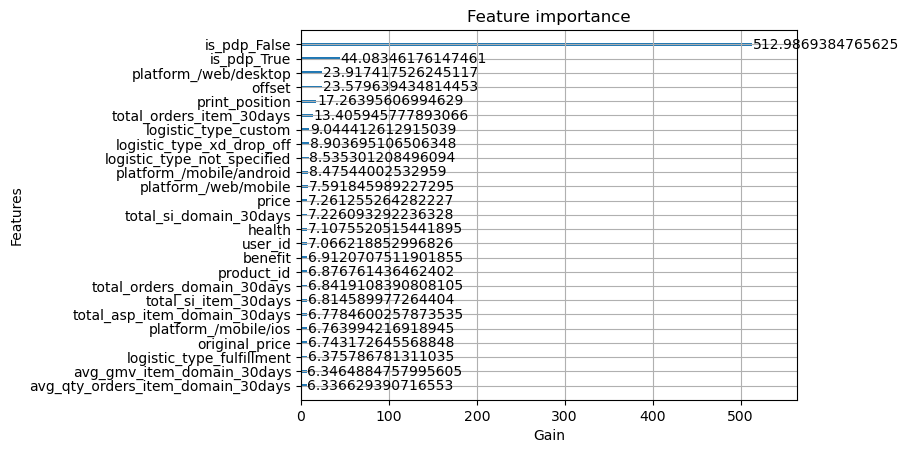

In [220]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_random_2.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

#### Prueba 3:

 Ahora utilicemos los parametros que mejor performance dieron para volver a entrenar los datos.

In [61]:
%%capture
model_xgb_3 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [62]:
%%capture
param_dist_3 = {'max_depth': stats.randint(5,7),
              'learning_rate': stats.uniform(0.01, 0.05),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.3, 0.9),
              'min_child_weight': stats.randint(2,4),
              'n_estimators': stats.randint(200, 1000)
             }
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

xgb_random_3 = RandomizedSearchCV(model_xgb_3,param_dist_3, cv=cv, verbose=1, n_jobs=1,scoring='roc_auc',n_iter=100,random_state=41)
xgb_random_3.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], eval_metric='auc', verbose=True)

In [63]:
xgb_random_3.best_params_

{'colsample_bytree': 0.9912674145136158,
 'learning_rate': 0.05253207397986486,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 940,
 'subsample': 0.7489120185002297}

In [64]:
xgb_random_3.best_score_

0.8935347767645035

In [65]:
# Print the accuracy for each iteration
for i, score in enumerate(xgb_random_3.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8611
Iteraciones 2: auc_roc = 0.8661
Iteraciones 3: auc_roc = nan
Iteraciones 4: auc_roc = 0.8932
Iteraciones 5: auc_roc = 0.8710
Iteraciones 6: auc_roc = 0.8928
Iteraciones 7: auc_roc = 0.8732
Iteraciones 8: auc_roc = 0.8845
Iteraciones 9: auc_roc = 0.8850
Iteraciones 10: auc_roc = nan
Iteraciones 11: auc_roc = nan
Iteraciones 12: auc_roc = 0.8671
Iteraciones 13: auc_roc = 0.8751
Iteraciones 14: auc_roc = 0.8930
Iteraciones 15: auc_roc = nan
Iteraciones 16: auc_roc = nan
Iteraciones 17: auc_roc = 0.8666
Iteraciones 18: auc_roc = 0.8750
Iteraciones 19: auc_roc = 0.8709
Iteraciones 20: auc_roc = 0.8913
Iteraciones 21: auc_roc = 0.8901
Iteraciones 22: auc_roc = 0.8929
Iteraciones 23: auc_roc = 0.8838
Iteraciones 24: auc_roc = 0.8885
Iteraciones 25: auc_roc = 0.8800
Iteraciones 26: auc_roc = 0.8674
Iteraciones 27: auc_roc = 0.8932
Iteraciones 28: auc_roc = 0.8677
Iteraciones 29: auc_roc = 0.8645
Iteraciones 30: auc_roc = 0.8697
Iteraciones 31: auc_roc = 0.8611
I

In [67]:
# Predict on the evaluation set
y_pred_3 = xgb_random_3.predict_proba(X_test)[:,1]
y_pred_3

array([4.54495326e-02, 1.26149738e-04, 1.07915707e-01, ...,
       1.31775188e-04, 1.24266498e-01, 1.09852044e-04], dtype=float32)

In [68]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_3})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.3.csv", sep=",", index=False)